Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
airbnb <-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
airbnb_selec <- airbnb[, c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
df_madrid<-subset(airbnb_selec, City=="Madrid" & Room.Type=="Entire home/apt" & Neighbourhood != '', select = -c(Room.Type,City))

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [4]:
df_madrid$Square.Meters<-df_madrid$Square.Feet*0.092903

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [5]:
numNA <- nrow(df_madrid[which(is.na(df_madrid$Square.Meters)),])
print(paste("Numero de apartamentos con NA en Square.Meters:", numNA))
print(paste("Porcentaje de apartamentos con NA en Square.Meters:", numNA/nrow(df_madrid)*100))

[1] "Numero de apartamentos con NA en Square.Meters: 5254"
[1] "Porcentaje de apartamentos con NA en Square.Meters: 93.8046777361185"


De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [6]:
num0 <- nrow(df_madrid[which(df_madrid$Square.Meters==0),])
print(paste("Numero de apartamentos con 0 en Square.Meters:", num0))
print(paste("Porcentaje de apartamentos con 0 en Square.Meters:", num0/(nrow(df_madrid)-numNA)*100))

[1] "Numero de apartamentos con 0 en Square.Meters: 128"
[1] "Porcentaje de apartamentos con 0 en Square.Meters: 36.8876080691643"


Reemplazar todos los 0m^2 por NA 

In [7]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0]<-NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

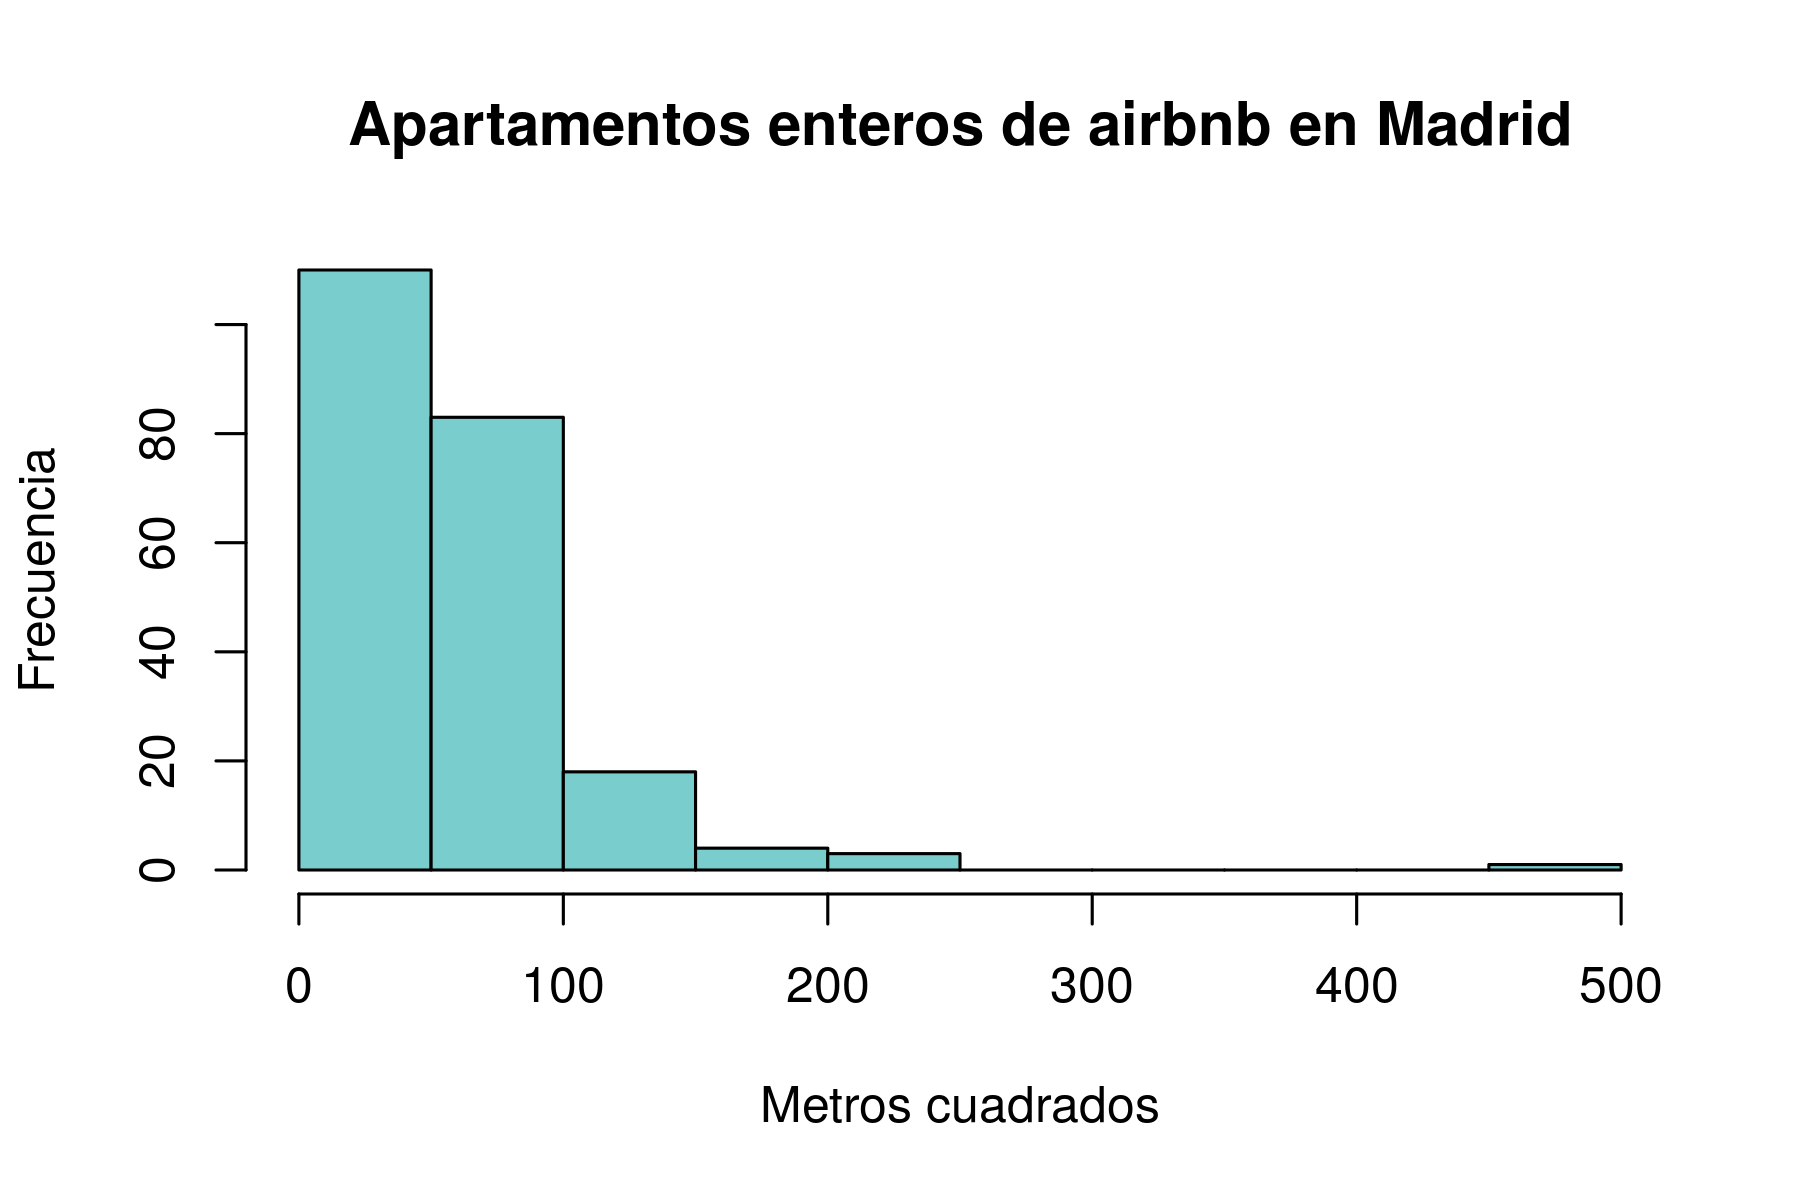

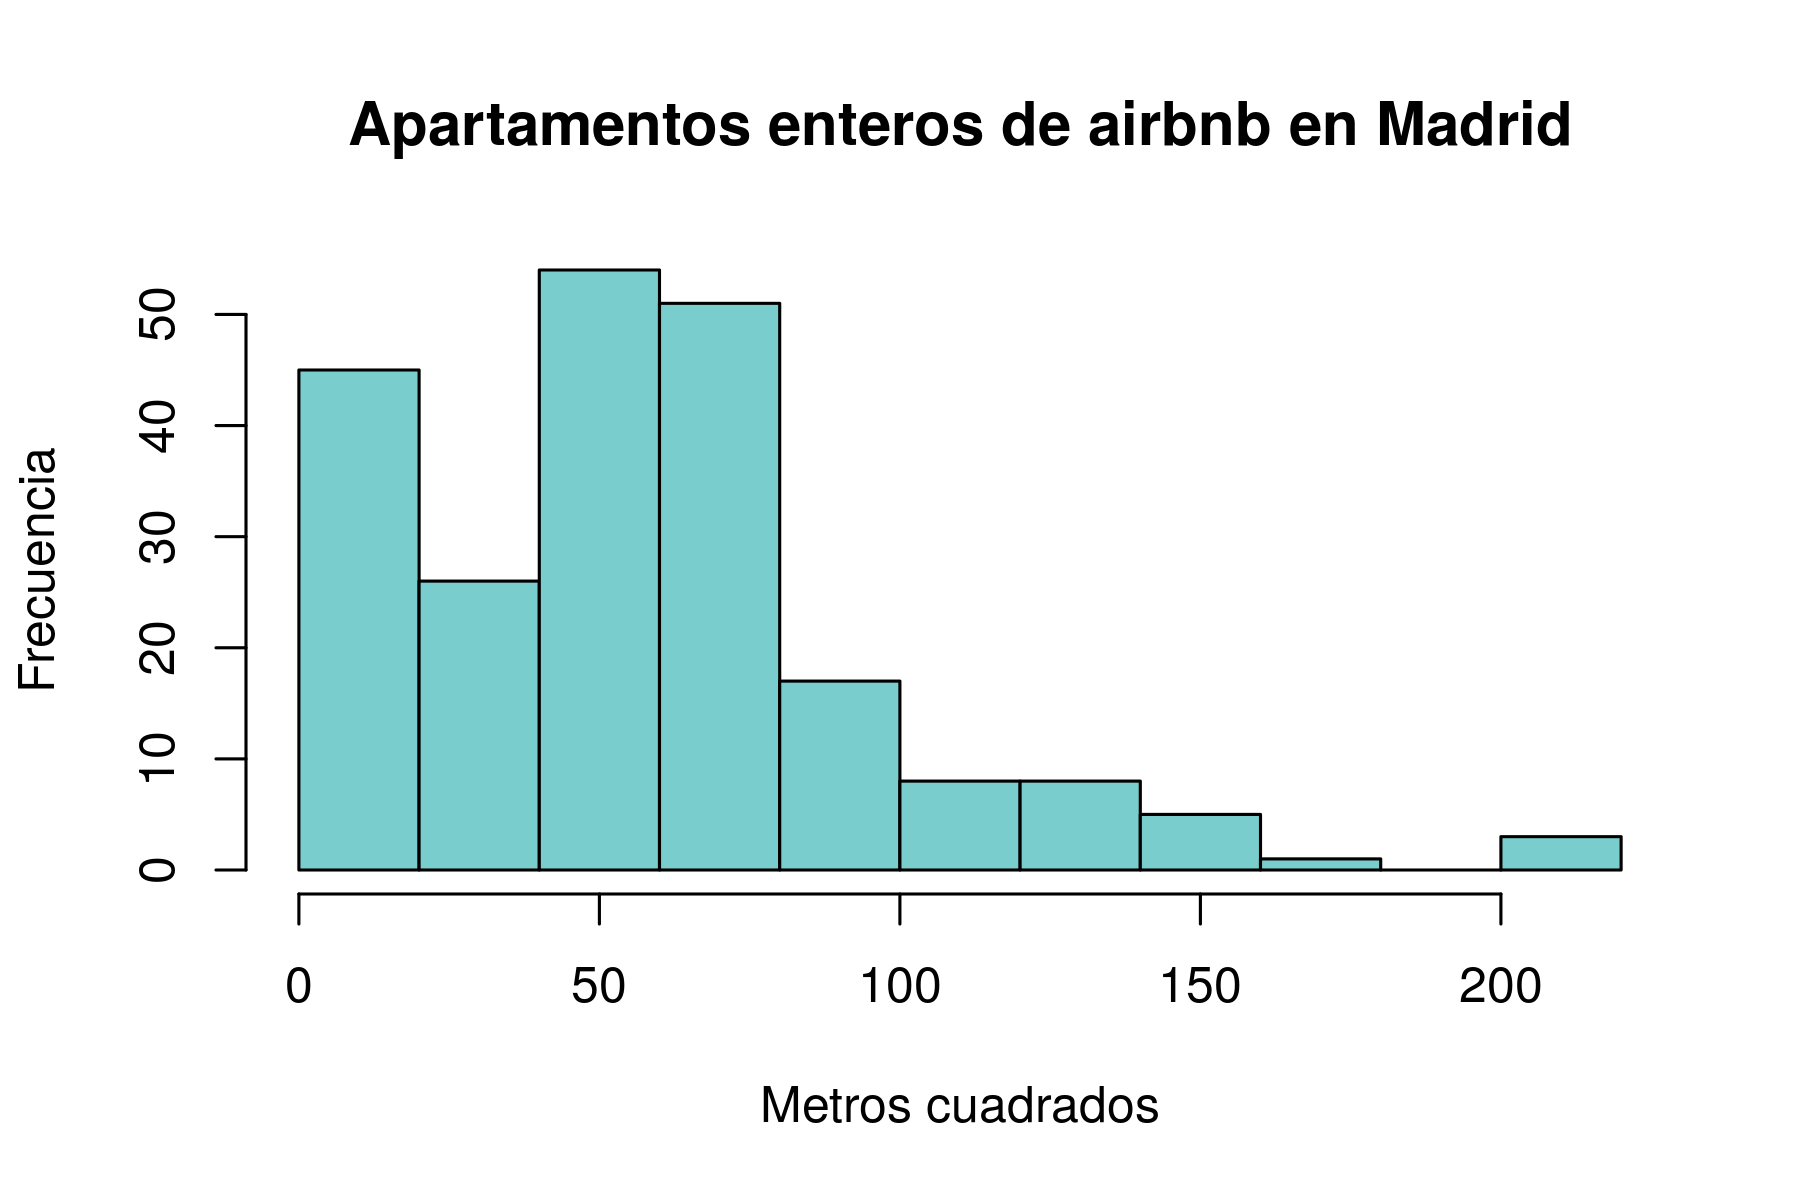

In [8]:
hist(df_madrid$Square.Meters, col="darkslategray3", xlab="Metros cuadrados", ylab="Frecuencia", main="Apartamentos enteros de airbnb en Madrid")
df_madrid$Square.Meters[df_madrid$Square.Meters>400]<-NA
hist(df_madrid$Square.Meters, col="darkslategray3", xlab="Metros cuadrados", ylab="Frecuencia", main="Apartamentos enteros de airbnb en Madrid")

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [9]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20]<-NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [10]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [11]:
GroupBarrios <- df_madrid %>% group_by(Neighbourhood) %>% summarize(num_no_na=length(na.omit(Square.Meters)), num_total=length(Square.Meters))

for (i in (1:length(GroupBarrios$num_no_na))) {
    if (GroupBarrios$num_no_na[i]==0) {
        df_madrid<- df_madrid[!(df_madrid$Neighbourhood == GroupBarrios$Neighbourhood[i]),]
    }
}

GroupBarrios <- df_madrid %>% group_by(Neighbourhood) %>% summarize(num_no_na=length(na.omit(Square.Meters)), num_total=length(Square.Meters))

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

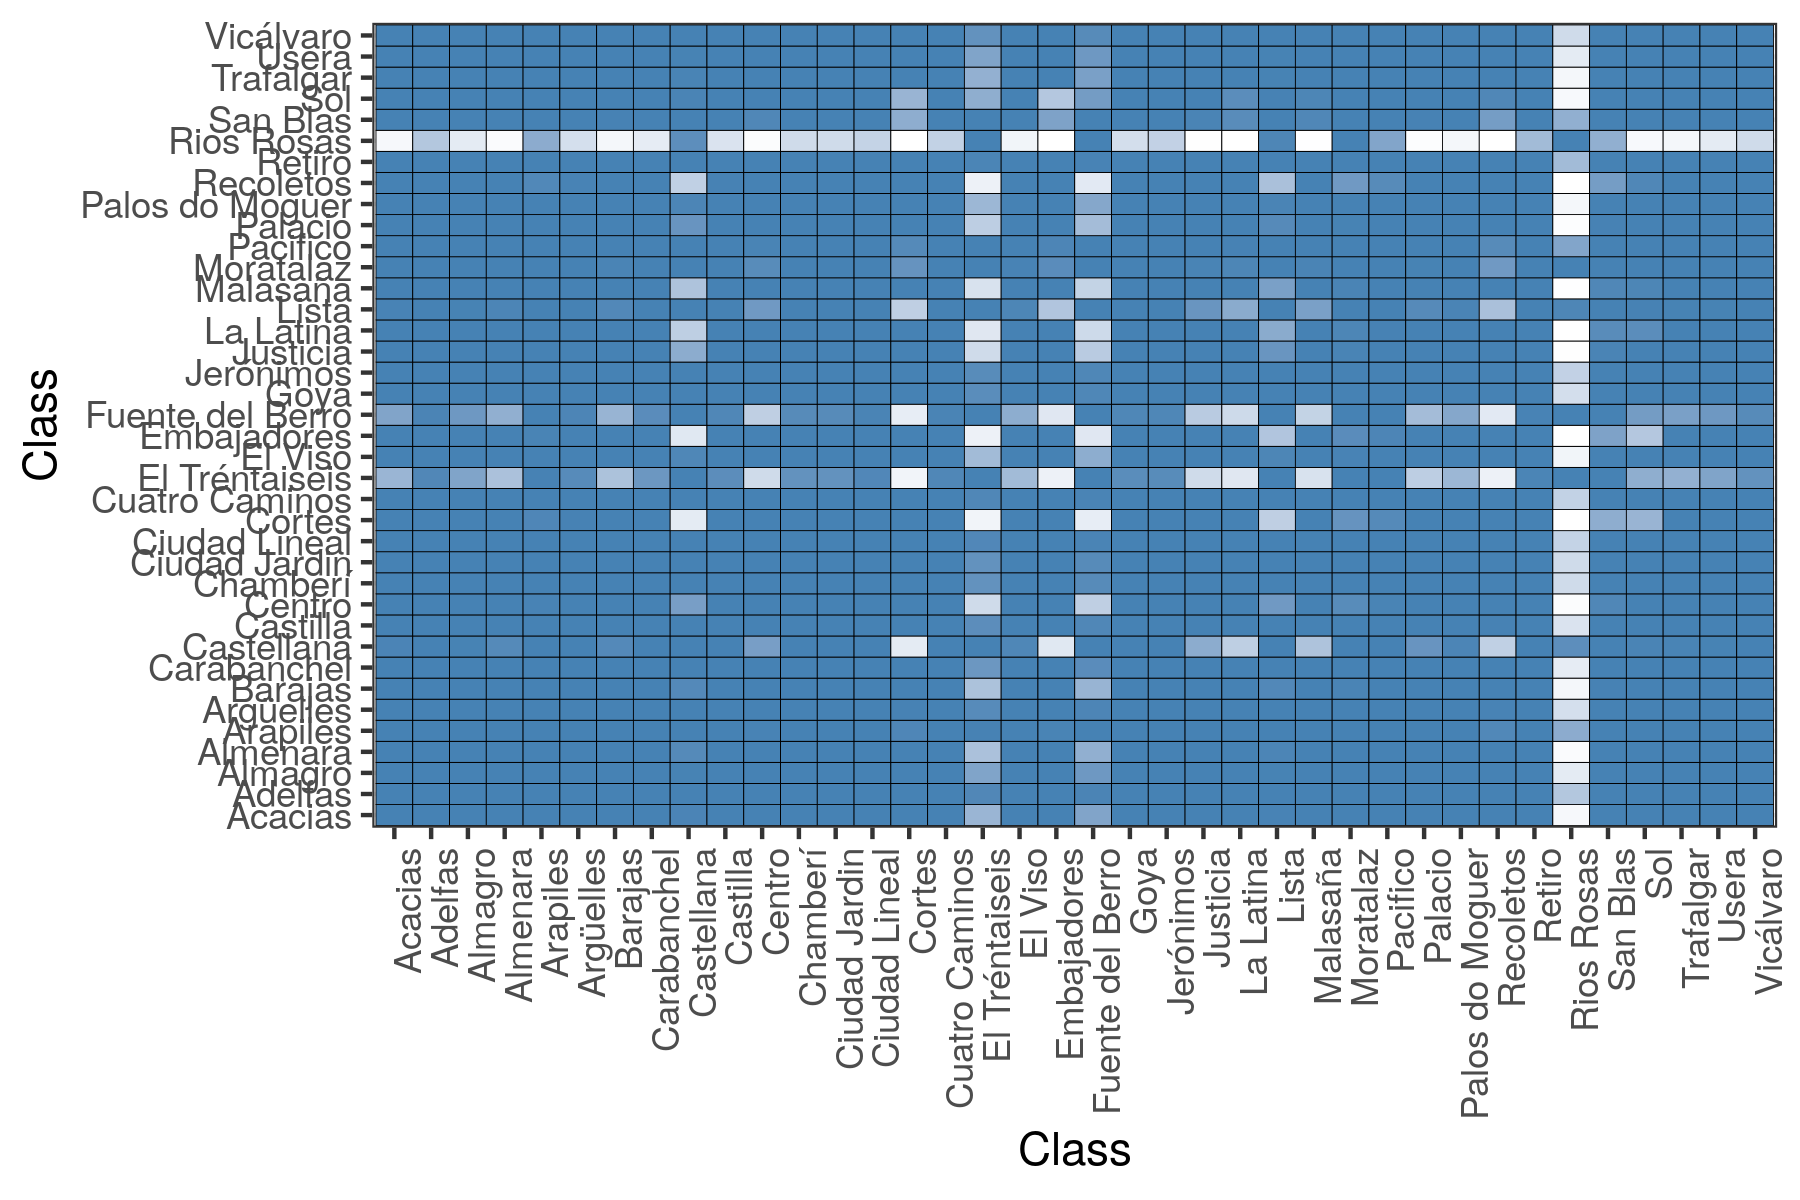

In [12]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [13]:
library(dendextend)


---------------------
Welcome to dendextend version 1.15.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




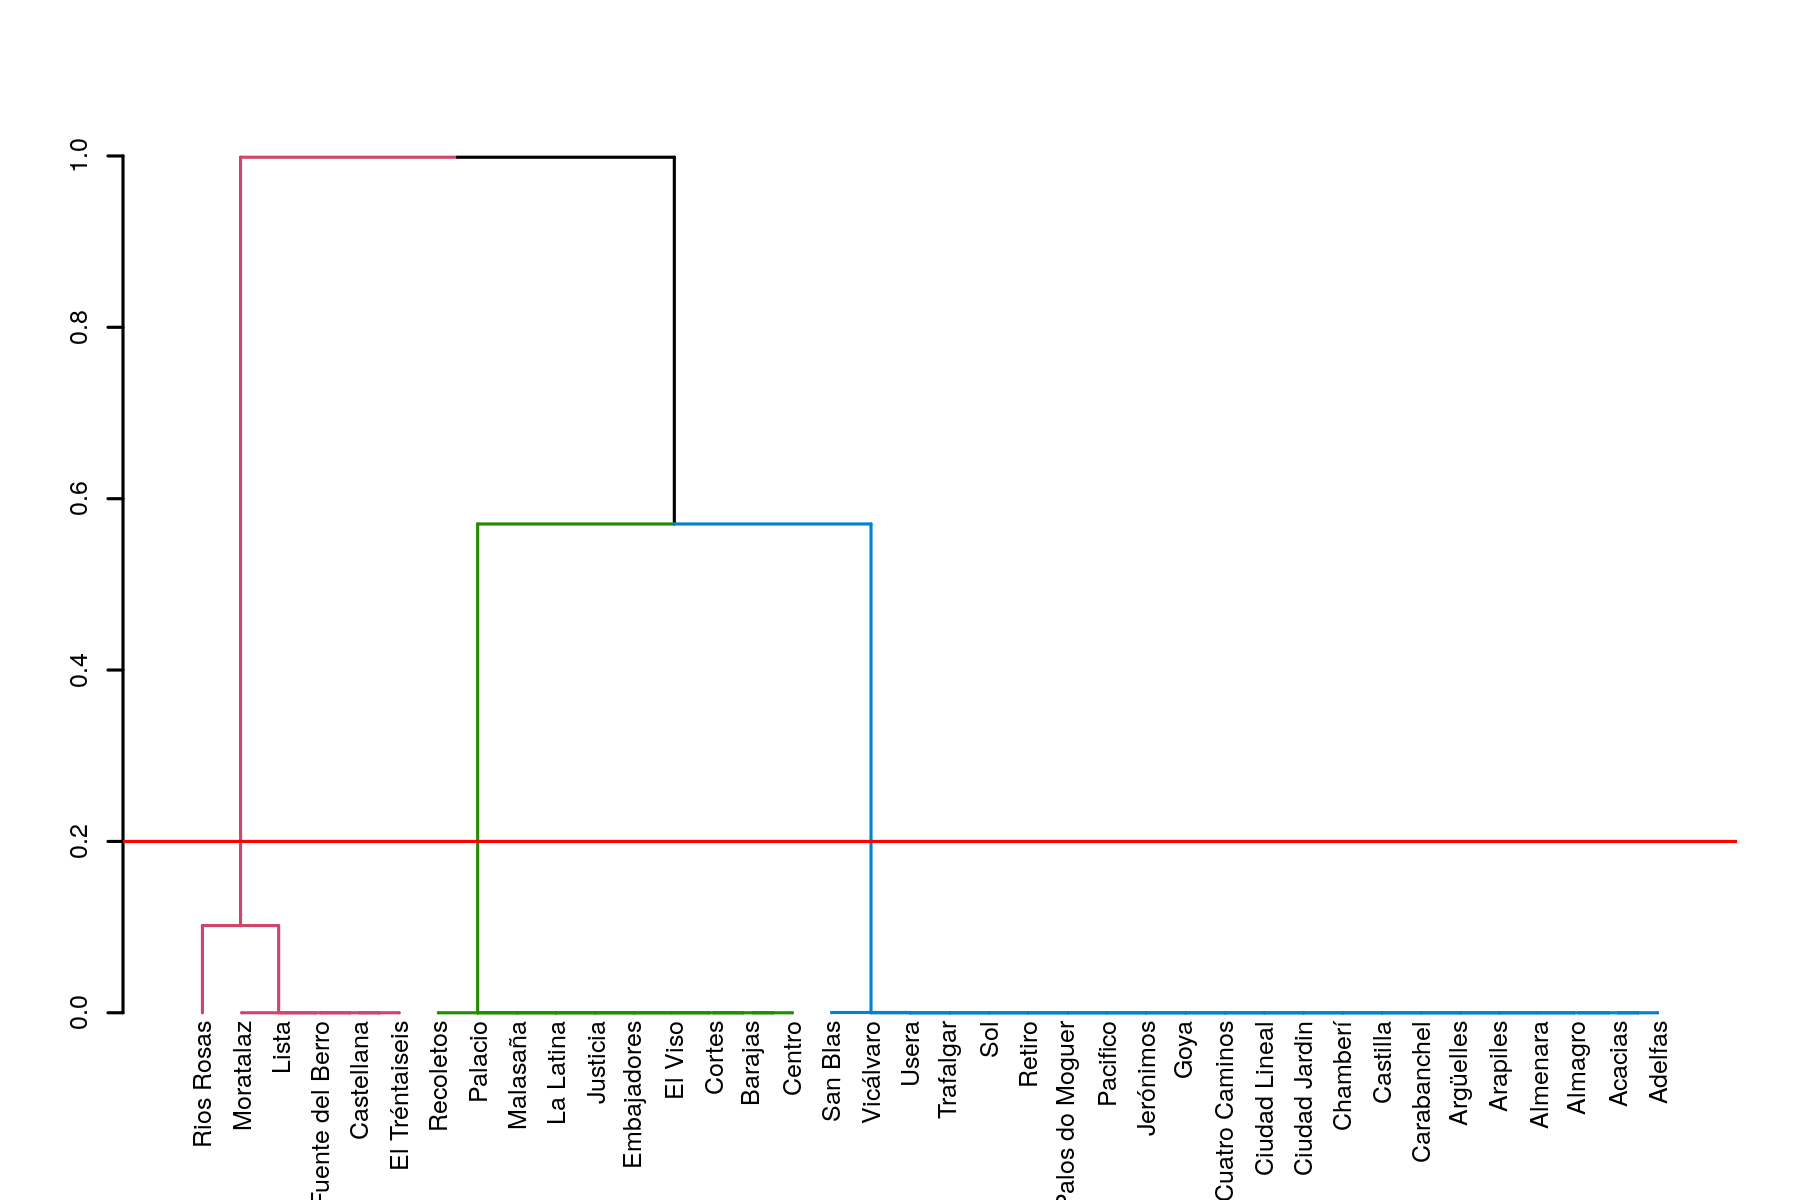

In [14]:
d <- as.dist(1-resm) 
hc <- hclust(d, method="complete")
hcd <- as.dendrogram(hc)
par(cex=0.5)
plot(color_branches(hcd, k=3))
abline(h=0.2,col="red")

¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

In [15]:
paste("El punto de corte más aconsejable sería cualquier punto entre 0.1 y 0.57 lo que genera 3 clusters.")

[1] "El punto de corte más aconsejable sería cualquier punto entre 0.1 y 0.57 lo que genera 3 clusters."

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [16]:
cl <- cutree_1h.dendrogram(hcd,h=0.2)
GroupBarrios$neighb_id = factor(cl)
df_madrid_cluster <- subset(merge(df_madrid, GroupBarrios), select = -c(num_no_na,num_total))

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [17]:
df_madrid_sin_na<-df_madrid_cluster[!is.na(df_madrid_cluster$Square.Meters),]
set.seed(12)
idx<-sample(1:nrow(df_madrid_sin_na),0.7*nrow(df_madrid_sin_na),)
train<-df_madrid_sin_na[idx,]
test<-df_madrid_sin_na[-idx,]

In [18]:
SCOPE <- (~.+train$Neighbourhood +train$Accommodates +train$Bathrooms +train$Bedrooms +train$Beds +train$Price +train$Guests.Included +train$Extra.People +train$Review.Scores.Rating +train$Latitude +train$Longitude +train$neighb_id)
modelo.inicial <- lm(train$Square.Meters~1)
add1(modelo.inicial, scope=SCOPE, test="F")

Warning message in add1.lm(modelo.inicial, scope = SCOPE, test = "F"):
“using the 115/121 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,141475.58,820.2193,NA,NA
train$Neighbourhood,30,44681.2430,96794.34,836.5723,1.3848302,1.220243e-01
train$Accommodates,1,56281.4035,85194.18,763.8920,78.6143735,8.953206e-15
train$Bathrooms,1,57925.3556,83550.23,761.6512,82.5026761,2.769889e-15
train$Bedrooms,1,80027.4716,61448.11,726.3169,154.9806652,2.722515e-23
train$Beds,1,44730.4517,96745.13,778.5139,55.0200687,1.928539e-11
train$Price,1,56793.6426,84681.94,763.1984,79.8097384,6.226588e-15
train$Guests.Included,1,24900.7319,116574.85,799.9560,25.4187510,1.669111e-06
train$Extra.People,1,11805.1492,129670.43,812.1992,10.8337168,1.312093e-03


In [19]:
model.update <- update(modelo.inicial, .~. +train$Bedrooms)
add1(model.update, scope=SCOPE, test="F")
summary(model.update)

Warning message in add1.lm(model.update, scope = SCOPE, test = "F"):
“using the 115/120 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,61448.11,726.3169,NA,NA
train$Neighbourhood,30,1.861420e+04,42833.91,744.8176,1.274729e+00,1.914331e-01
train$Accommodates,1,1.452687e+03,59995.42,725.5655,2.832955e+00,9.501488e-02
train$Bathrooms,1,7.280167e+03,54167.94,713.8149,1.572479e+01,1.265899e-04
train$Beds,1,4.923801e+01,61398.87,728.2247,9.382660e-02,7.599121e-01
train$Price,1,8.058047e+03,53390.06,712.1515,1.765856e+01,5.190599e-05
train$Guests.Included,1,3.407804e+02,61107.33,727.6773,6.524798e-01,4.208667e-01
train$Extra.People,1,1.922028e+03,59526.08,724.6623,3.777794e+00,5.433841e-02
train$Review.Scores.Rating,1,2.421144e+01,61423.90,728.2715,4.611785e-02,8.303356e-01



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.058 -13.665  -4.032   9.557  91.615 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      26.358      4.128   6.385 3.53e-09 ***
train$Bedrooms   27.349      2.163  12.642  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.71 on 118 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5753,	Adjusted R-squared:  0.5717 
F-statistic: 159.8 on 1 and 118 DF,  p-value: < 2.2e-16


In [20]:
model.update2 <- update(model.update, .~. +train$neighb_id)
add1(model.update2, scope=SCOPE, test="F")
summary(model.update2)

Warning message in add1.lm(model.update2, scope = SCOPE, test = "F"):
“using the 115/120 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,51338.10,709.6445,NA,NA
train$Neighbourhood,28,8504.18568,42833.91,744.8176,0.6239785,0.9210691572
train$Accommodates,1,1408.50211,49929.60,708.4453,3.2441228,0.0743006048
train$Bathrooms,1,3317.32852,48020.77,703.9625,7.9443285,0.0056810010
train$Beds,1,76.92317,51261.18,711.4720,0.1725705,0.6786114712
train$Price,1,6115.63996,45222.46,697.0580,15.5519758,0.0001383920
train$Guests.Included,1,173.99380,51164.11,711.2541,0.3910806,0.5329709880
train$Extra.People,1,4950.26693,46387.83,699.9839,12.2721987,0.0006558487
train$Review.Scores.Rating,1,239.33943,51098.76,711.1071,0.5386439,0.4644889812



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms + train$neighb_id)

Residuals:
    Min      1Q  Median      3Q     Max 
-38.327 -12.290  -2.256   8.057  89.544 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        38.169      4.506   8.471 8.73e-14 ***
train$Bedrooms     24.102      2.093  11.516  < 2e-16 ***
train$neighb_id2  -15.997      4.041  -3.958 0.000131 ***
train$neighb_id3   28.703     10.542   2.723 0.007477 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.53 on 116 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.6557,	Adjusted R-squared:  0.6468 
F-statistic: 73.65 on 3 and 116 DF,  p-value: < 2.2e-16


In [21]:
model.update3 <- update(model.update2, .~. +train$Price)
add1(model.update3, scope=SCOPE, test="F")
summary(model.update3)

Warning message in add1.lm(model.update3, scope = SCOPE, test = "F"):
“using the 115/119 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,45222.46,697.0580,NA,NA
train$Neighbourhood,28,6263.926462,38958.53,735.9119,0.49383797,0.9815499113
train$Accommodates,1,680.955585,44541.50,697.3131,1.72755687,0.1913848710
train$Bathrooms,1,1479.233436,43743.23,695.2334,3.82124029,0.0530766081
train$Beds,1,6.886323,45215.57,699.0404,0.01720988,0.8958611118
train$Guests.Included,1,29.381581,45193.08,698.9832,0.07346520,0.7868511898
train$Extra.People,1,4574.148295,40648.31,686.7948,12.71587285,0.0005328038
train$Review.Scores.Rating,1,222.559380,44999.90,698.4906,0.55887257,0.4562677495
train$Latitude,1,370.536982,44851.92,698.1118,0.93353142,0.3360102679



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms + train$neighb_id + 
    train$Price)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.679 -12.396  -1.661   8.230  82.699 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       33.39733    4.57541   7.299 4.17e-11 ***
train$Bedrooms    20.40195    2.33999   8.719 2.62e-14 ***
train$neighb_id2 -15.01042    3.89298  -3.856 0.000191 ***
train$neighb_id3  11.73384   11.63951   1.008 0.315539    
train$Price        0.11416    0.03635   3.140 0.002149 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.67 on 114 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.6691,	Adjusted R-squared:  0.6575 
F-statistic: 57.63 on 4 and 114 DF,  p-value: < 2.2e-16


In [22]:
model.update4 <- update(model.update3, .~. +train$Extra.People)
add1(model.update4, scope=SCOPE, test="F")
summary(model.update4)

Warning message in add1.lm(model.update4, scope = SCOPE, test = "F"):
“using the 115/119 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,40648.31,686.7948,NA,NA
train$Neighbourhood,28,5878.78274,34769.53,724.8299,0.51327428,0.97589697
train$Accommodates,1,24.51441,40623.80,688.7254,0.06758634,0.79536135
train$Bathrooms,1,1065.37141,39582.94,685.7405,3.01447033,0.08527427
train$Beds,1,339.82890,40308.48,687.8293,0.94423888,0.33328401
train$Guests.Included,1,375.76247,40272.55,687.7267,1.04501448,0.30886109
train$Review.Scores.Rating,1,192.15387,40456.16,688.2498,0.53196434,0.46730474
train$Latitude,1,530.83080,40117.48,687.2831,1.48197367,0.22602473
train$Longitude,1,22.02271,40626.29,688.7324,0.06071298,0.80582360



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms + train$neighb_id + 
    train$Price + train$Extra.People)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.484 -13.599   0.105   8.886  70.263 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         30.02379    4.43755   6.766 6.17e-10 ***
train$Bedrooms      18.51177    2.27914   8.122 6.33e-13 ***
train$neighb_id2   -17.51478    3.75645  -4.663 8.61e-06 ***
train$neighb_id3    20.12974   11.27849   1.785 0.076979 .  
train$Price          0.10948    0.03452   3.171 0.001954 ** 
train$Extra.People   0.74707    0.20272   3.685 0.000353 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.62 on 113 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.7046,	Adjusted R-squared:  0.6915 
F-statistic: 53.91 on 5 and 113 DF,  p-value: < 2.2e-16


In [23]:
model.update5 <- update(model.update4, .~. +train$Bathrooms)
add1(model.update5, scope=SCOPE, test="F")
summary(model.update5)
paste("El R^2 no mejora significativamente y complicaríamos el modelo al añadir la latitud por lo que nos quedamos con el model-update3")

Warning message in add1.lm(model.update5, scope = SCOPE, test = "F"):
“using the 115/118 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,39582.94,685.7405,NA,NA
train$Neighbourhood,28,5015.75179,34567.19,726.1587,0.43012239,0.9931576
train$Accommodates,1,31.90962,39551.03,687.6477,0.08874758,0.7663374
train$Beds,1,429.53852,39153.40,686.4857,1.20677222,0.2743710
train$Guests.Included,1,876.74418,38706.20,685.1646,2.49163882,0.1173240
train$Review.Scores.Rating,1,315.76919,39267.17,686.8194,0.88457128,0.3490135
train$Latitude,1,193.48002,39389.46,687.1770,0.54031718,0.4638656
train$Longitude,1,69.95577,39512.98,687.5370,0.19474953,0.6598589



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms + train$neighb_id + 
    train$Price + train$Extra.People + train$Bathrooms)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.855 -12.259  -1.267   8.718  70.517 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         23.79475    5.47330   4.347 3.07e-05 ***
train$Bedrooms      16.27474    2.54501   6.395 3.92e-09 ***
train$neighb_id2   -16.00867    3.83130  -4.178 5.87e-05 ***
train$neighb_id3    16.43844   11.36207   1.447 0.150776    
train$Price          0.09641    0.03493   2.760 0.006764 ** 
train$Extra.People   0.71202    0.20213   3.523 0.000622 ***
train$Bathrooms      8.16875    4.25017   1.922 0.057171 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.47 on 111 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.7141,	Adjusted R-squared:  0.6987 
F-statistic: 46.21 on 6 and 111 DF,  p-v

[1] "El R^2 no mejora significativamente y complicaríamos el modelo al añadir la latitud por lo que nos quedamos con el model-update3"

In [24]:
model.update6 <- update(model.update5, .~. +train$Guests.Included)
add1(model.update6, scope=SCOPE, test="F")
summary(model.update6)
paste("Los p-valores son mayores que el alpha crítico que habíamos escogido que era 0.2 por lo que no entra ninguna variable más en el modelo")

Warning message in add1.lm(model.update6, scope = SCOPE, test = "F"):
“using the 115/118 rows from a combined fit”


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,38706.20,685.1646,NA,NA
train$Neighbourhood,28,4573.634797,34132.56,726.7036,0.39241756,0.9966589
train$Accommodates,1,8.029188,38698.17,687.1408,0.02261558,0.8807390
train$Beds,1,192.397783,38513.80,686.5916,0.54451546,0.4621531
train$Review.Scores.Rating,1,158.542835,38547.65,686.6926,0.44830665,0.5045561
train$Latitude,1,172.122277,38534.07,686.6521,0.48687633,0.4868098
train$Longitude,1,38.123771,38668.07,687.0513,0.10746569,0.7436769



Call:
lm(formula = train$Square.Meters ~ train$Bedrooms + train$neighb_id + 
    train$Price + train$Extra.People + train$Bathrooms + train$Guests.Included)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.013 -11.611  -0.311   8.958  68.161 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            24.42054    5.55180   4.399 2.53e-05 ***
train$Bedrooms         16.55254    2.57877   6.419 3.58e-09 ***
train$neighb_id2      -16.36603    3.87066  -4.228 4.89e-05 ***
train$neighb_id3       14.01630   11.86193   1.182 0.239904    
train$Price             0.10022    0.03539   2.832 0.005510 ** 
train$Extra.People      0.74457    0.20743   3.590 0.000496 ***
train$Bathrooms         8.99229    4.40673   2.041 0.043687 *  
train$Guests.Included  -1.24232    1.70576  -0.728 0.467970    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.51 on 110 degrees of freedom
  (3 observations deleted due to

[1] "Los p-valores son mayores que el alpha crítico que habíamos escogido que era 0.2 por lo que no entra ninguna variable más en el modelo"

In [25]:
model <- lm(Square.Meters ~ Bathrooms+Bedrooms+Guests.Included+Price+Extra.People+neighb_id, data=train)
train<-train[(!is.na(train$Bathrooms) & !is.na(train$Bedrooms) & !is.na(train$Price)),]
test<-test[!is.na(test$Bathrooms),]
calcmse<-function(Square.Meters_real,Square.Meters_est){
  sum((Square.Meters_real-Square.Meters_est)^2)/length(Square.Meters_real)
}

paste("El MSE training es:",calcmse(Square.Meters_real=train$Square.Meters, Square.Meters_est=predict(model,train)))
paste("El MSE testing es:", calcmse(Square.Meters_real=test$Square.Meters,  Square.Meters_est=predict(model,test)))

[1] "El MSE training es: 355.00339887332"

[1] "El MSE testing es: 298.230689479037"

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

RMSE   Rsquared        MAE 
18.8415339  0.7154994 13.9242490

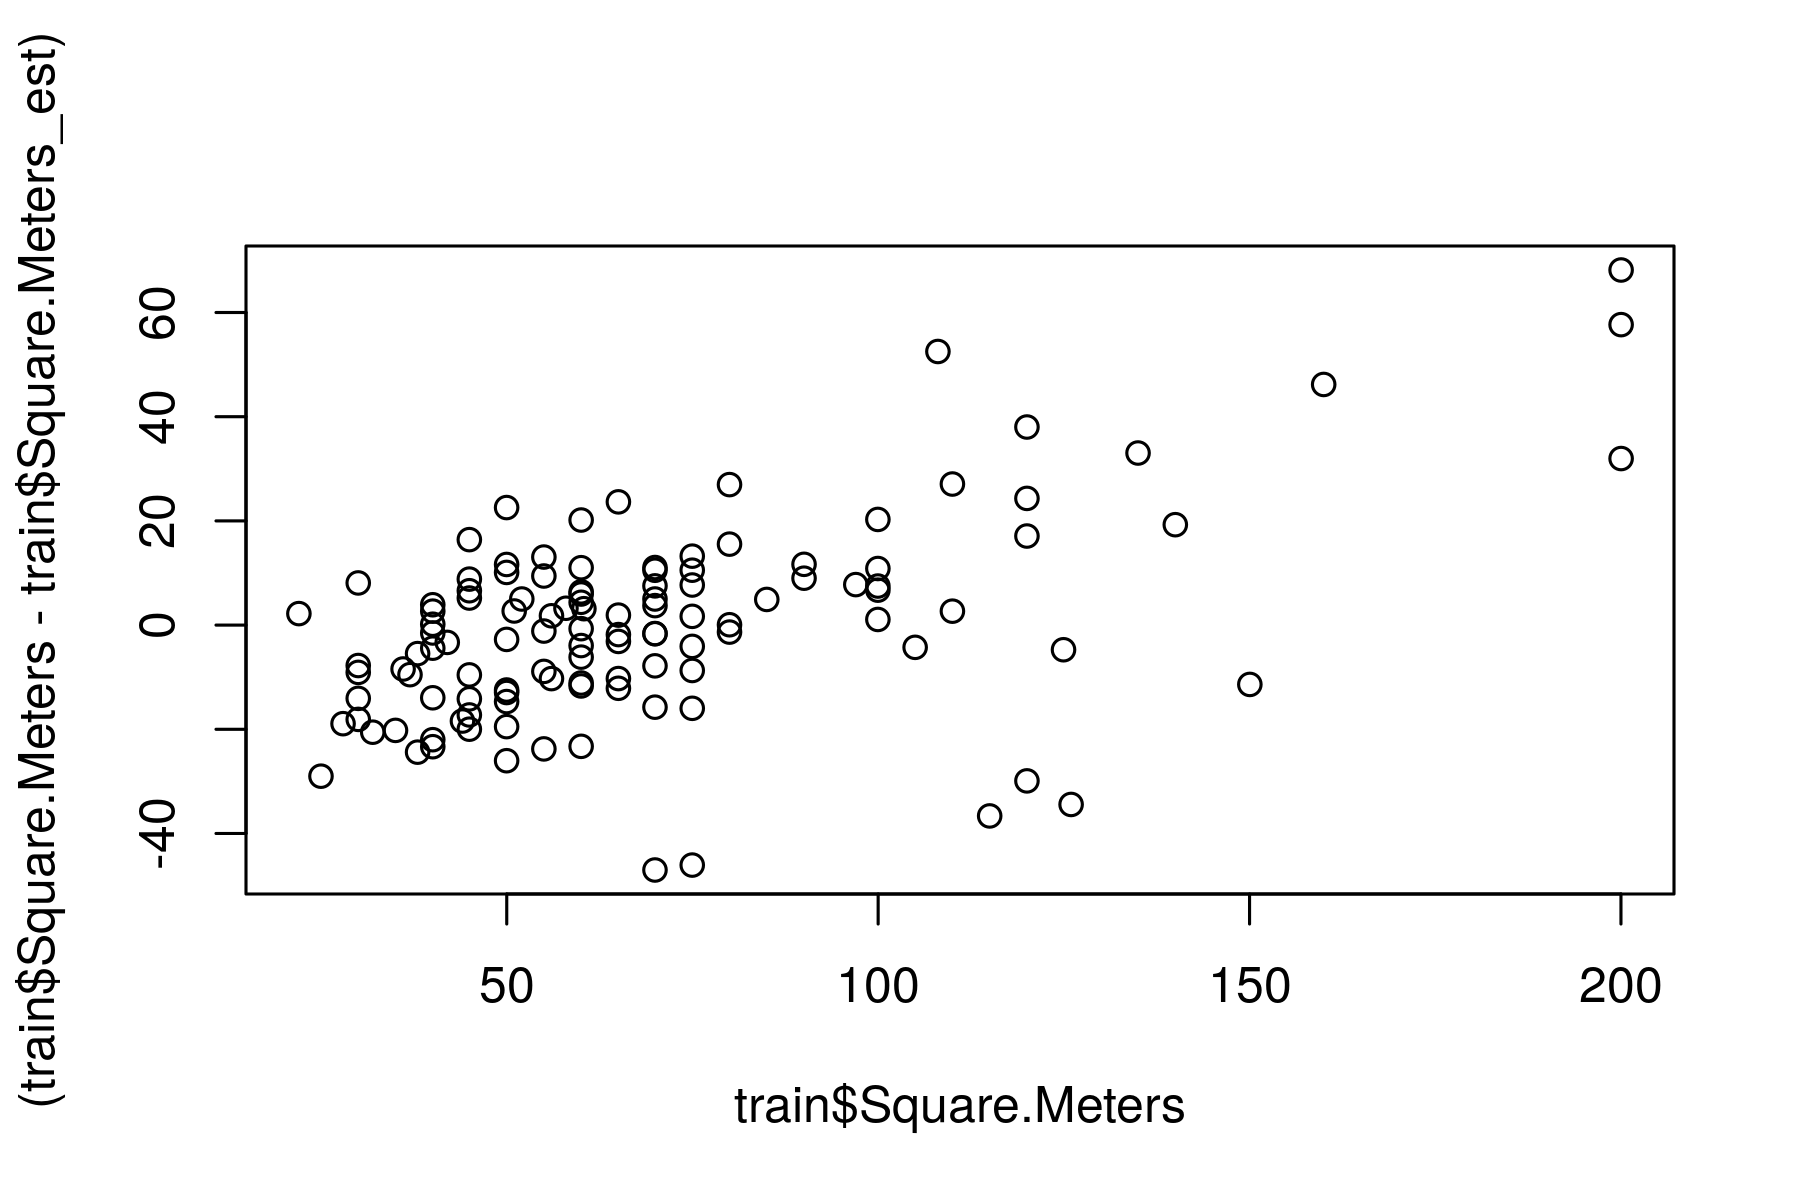

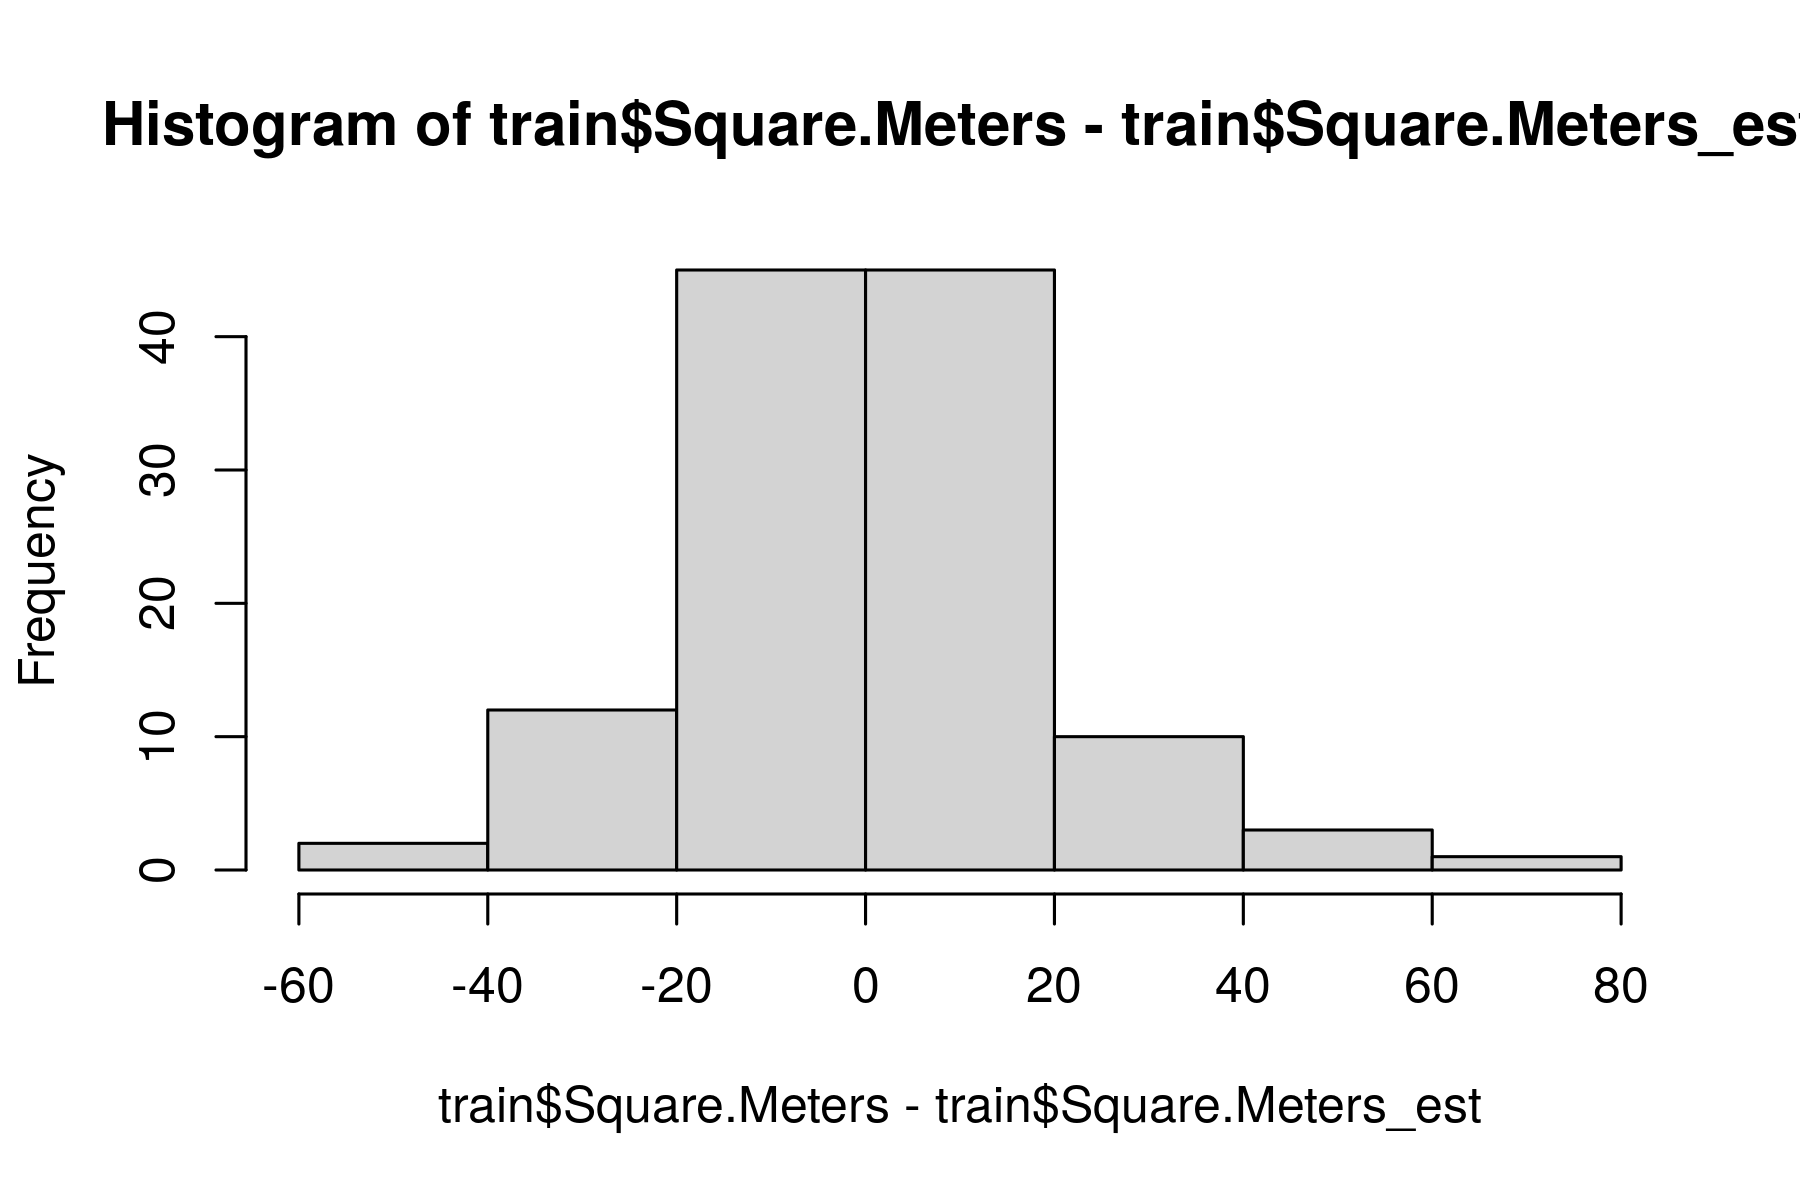

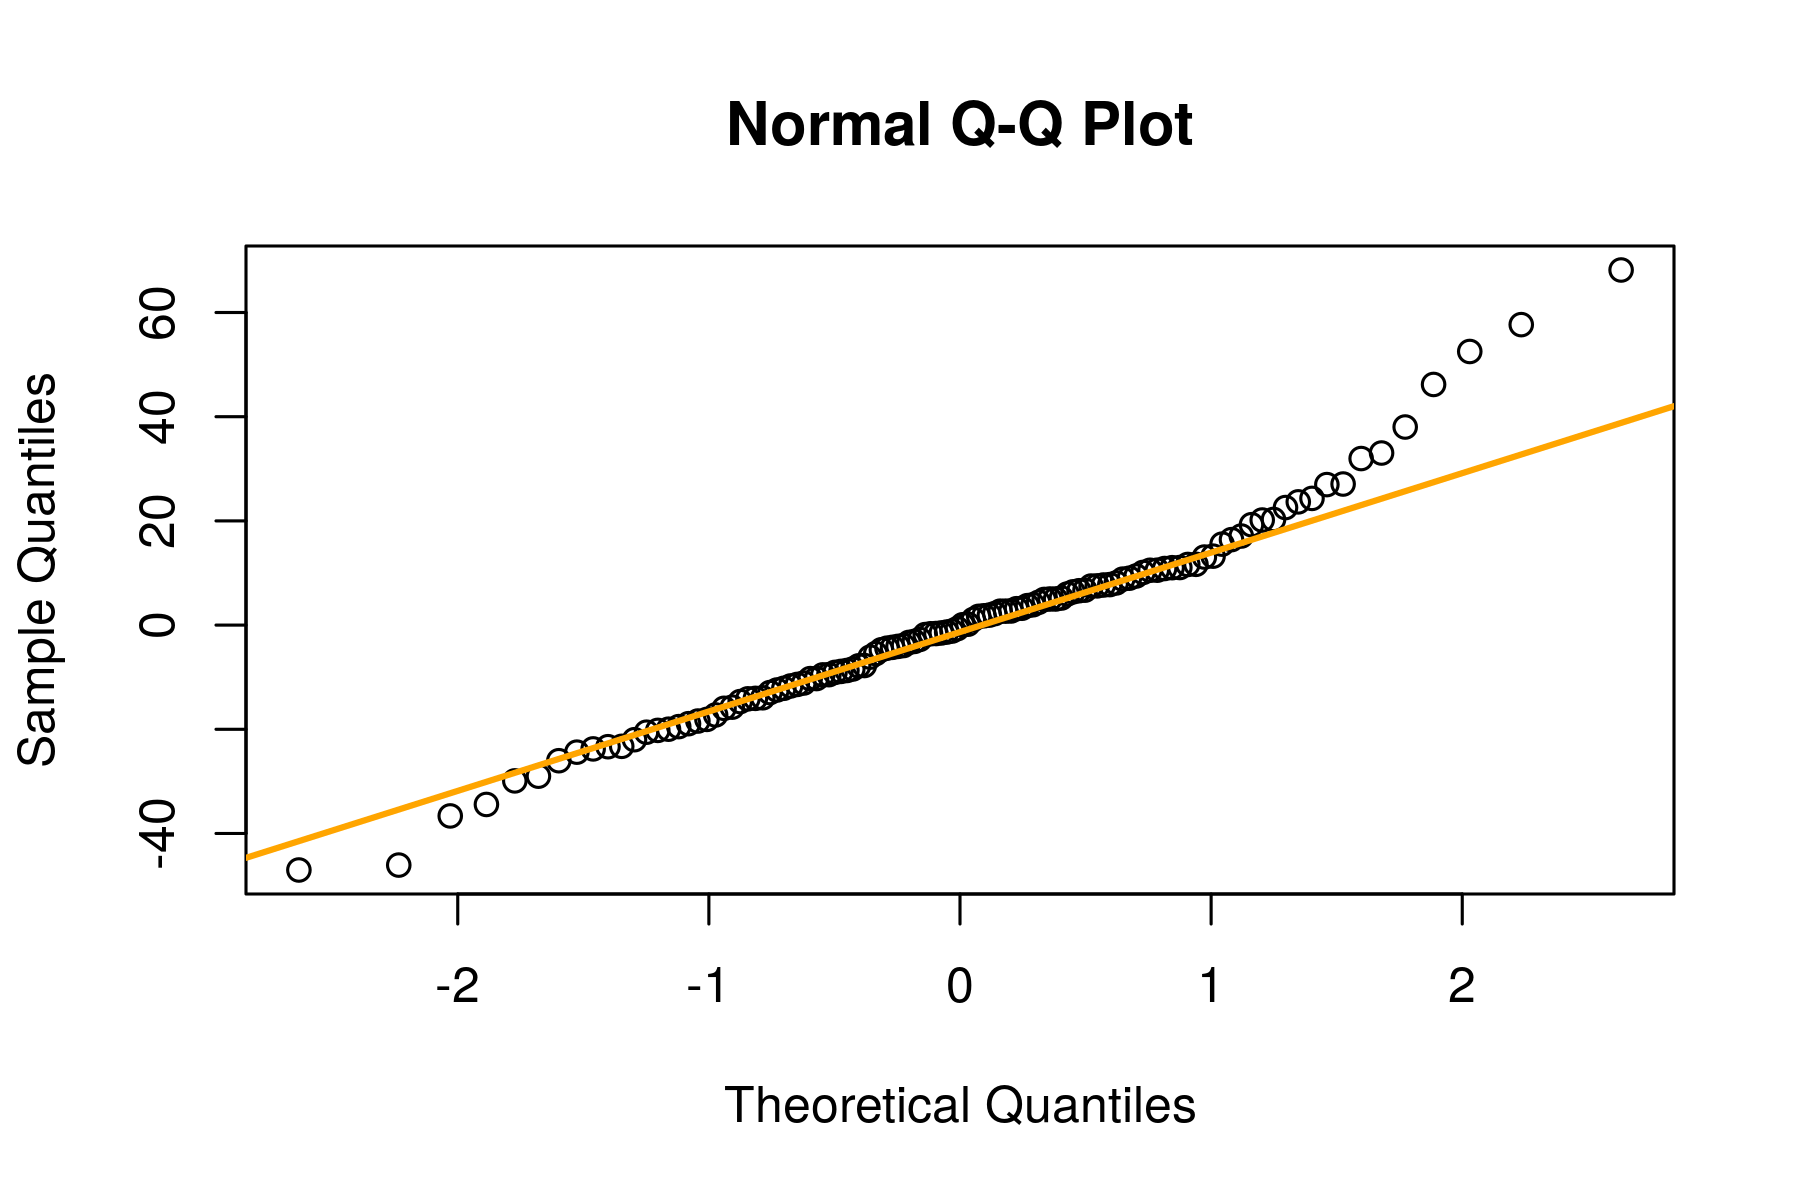

In [26]:
train$Square.Meters_est<-predict(model,train)
plot(train$Square.Meters,(train$Square.Meters-train$Square.Meters_est))
caret::postResample(pred=train$Square.Meters_est, obs= train$Square.Meters)

hist(train$Square.Meters-train$Square.Meters_est)

qqnorm(train$Square.Meters-train$Square.Meters_est)
qqline(train$Square.Meters-train$Square.Meters_est, col = 'orange', lwd =2)

#sqrt(mean((train$Square.Meters-train$Square.Meters_est)^2))

RMSE Rsquared      MAE 
17.26936  0.70845 13.26054

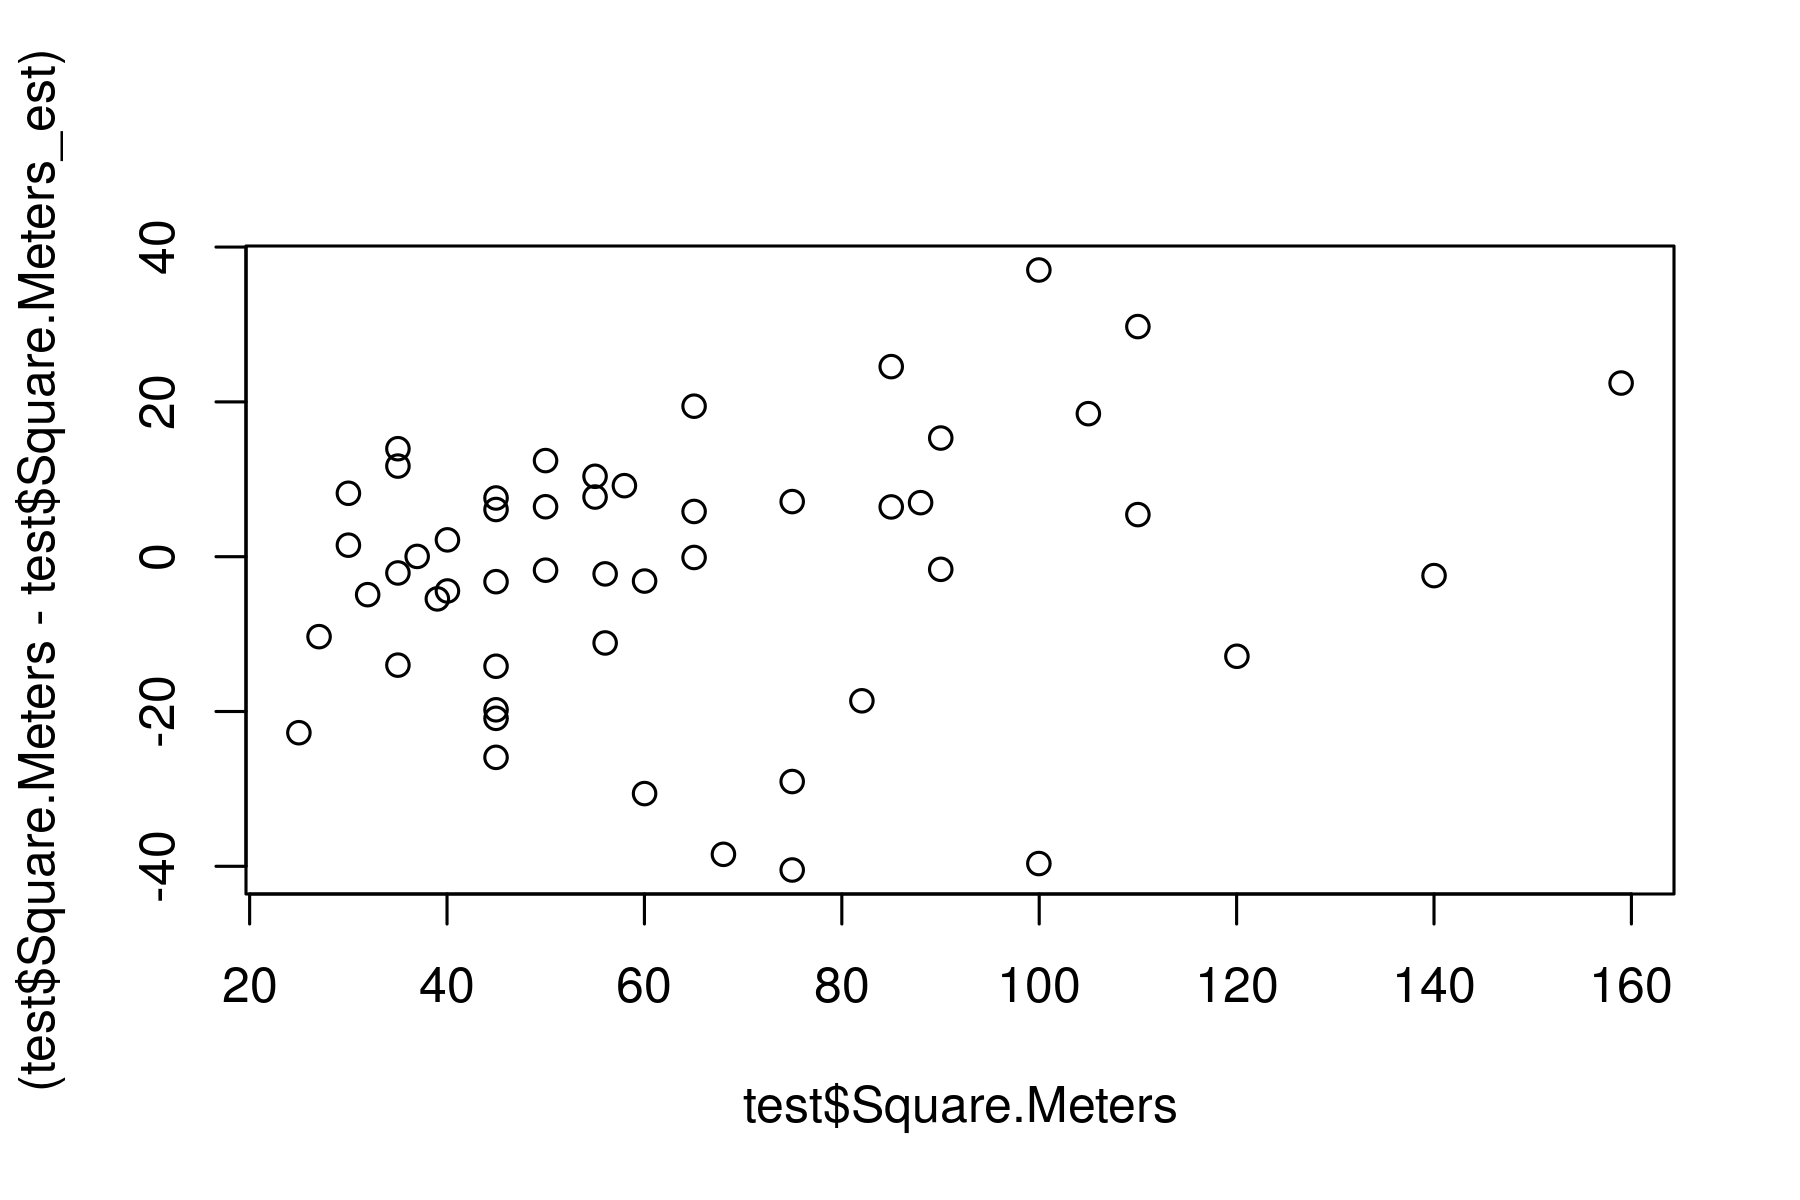

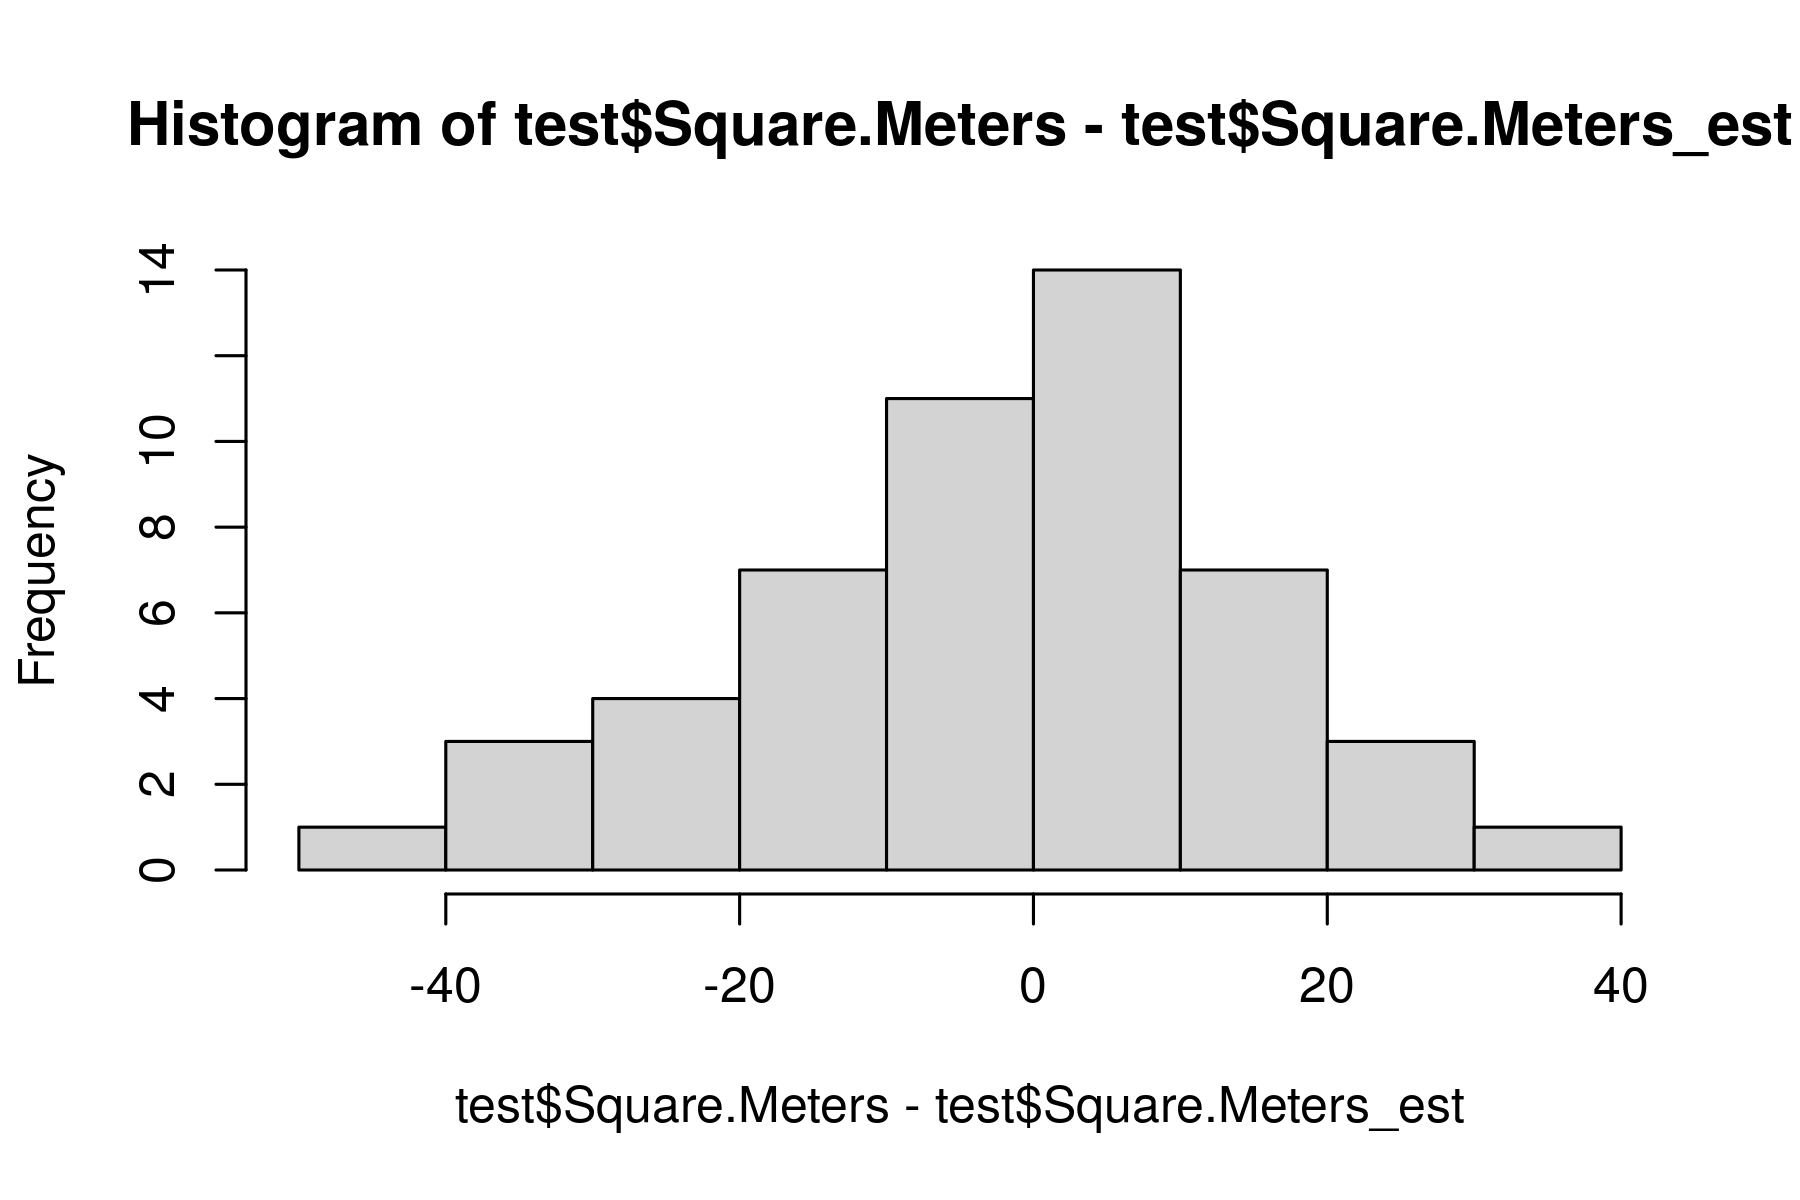

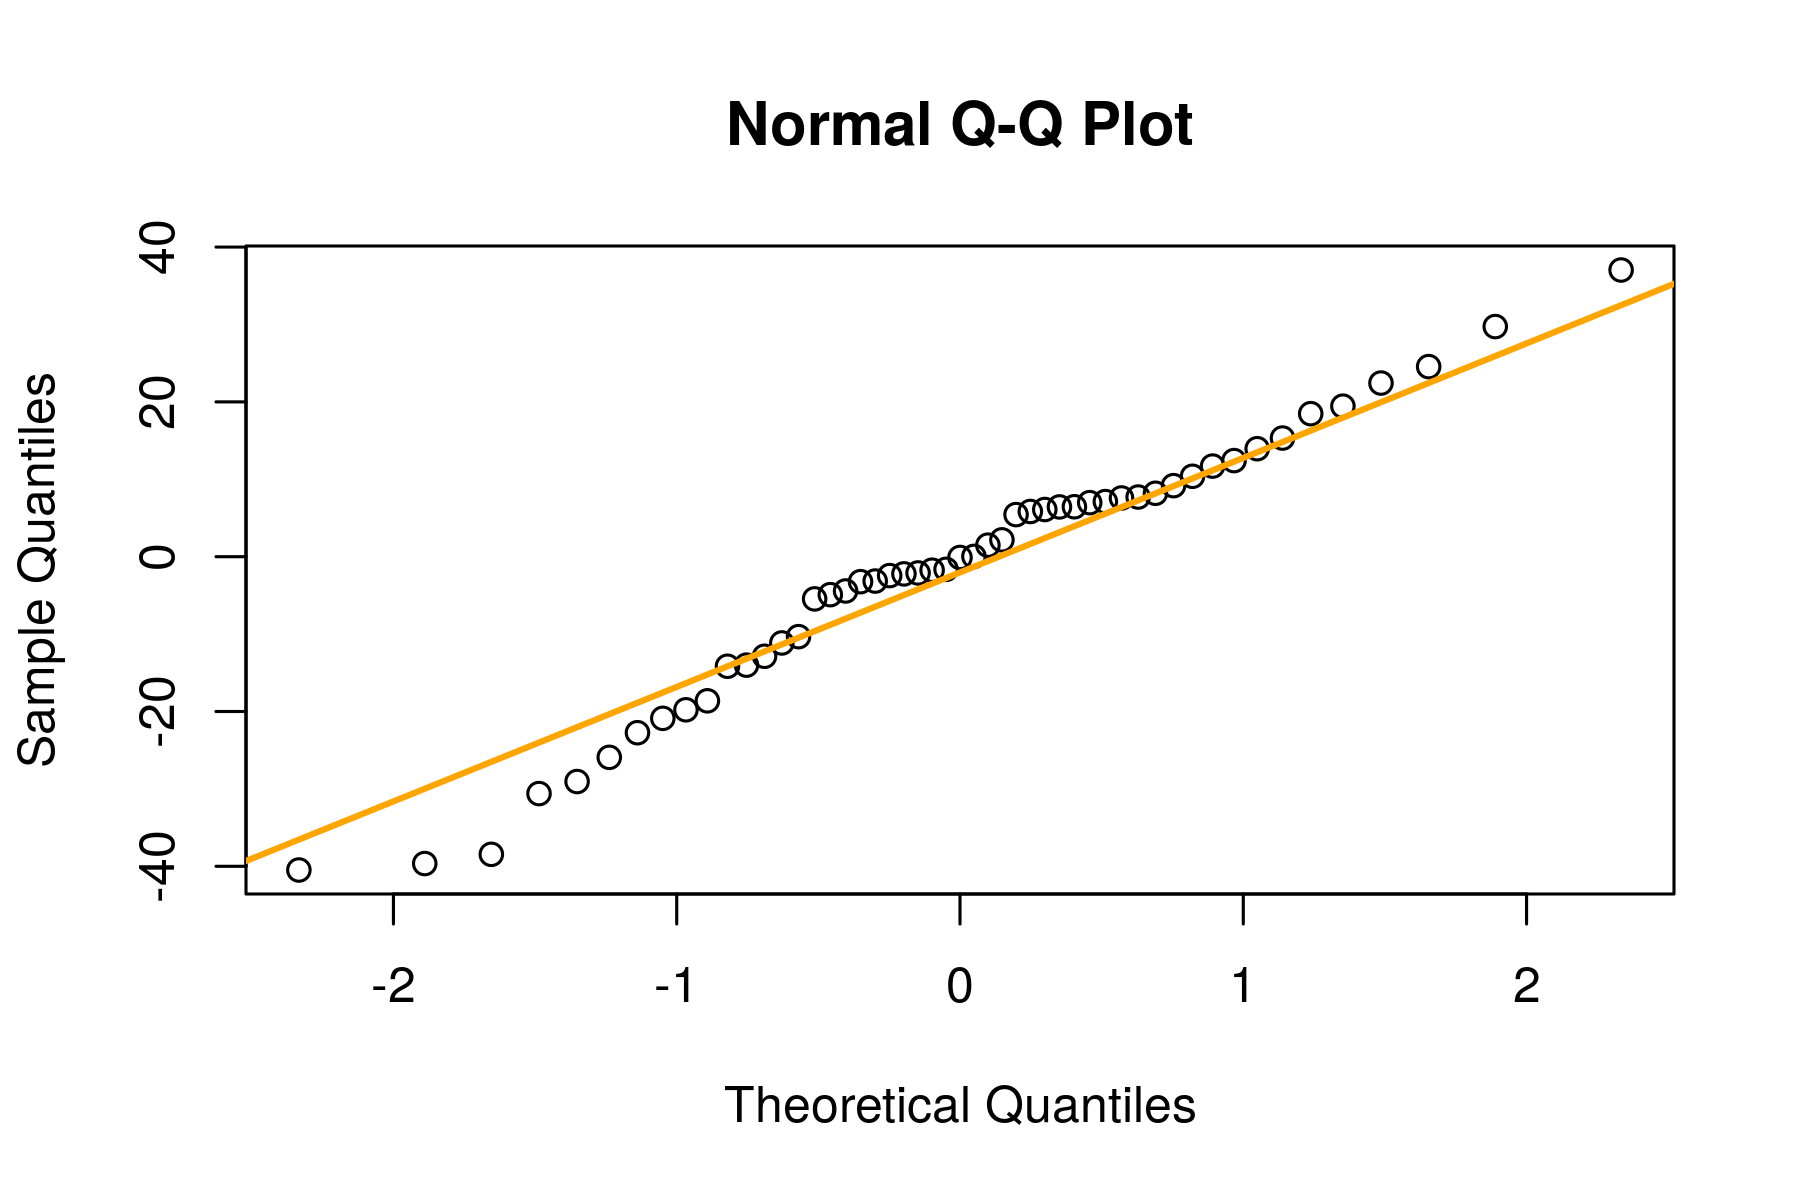

In [27]:
test$Square.Meters_est<-predict(model,test)
plot(test$Square.Meters,(test$Square.Meters-test$Square.Meters_est))
caret::postResample(pred=test$Square.Meters_est, obs= test$Square.Meters)

hist(test$Square.Meters-test$Square.Meters_est)

qqnorm(test$Square.Meters-test$Square.Meters_est)
qqline(test$Square.Meters-test$Square.Meters_est, col = 'orange', lwd =2)

#sqrt(mean((test$Square.Meters-test$Square.Meters_est)^2))


Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [28]:
anuncio <- data.frame(Bathrooms=1, Bedrooms=3, Guests.Included=2, Price= 80, Extra.People=4, neighb_id=as.factor(1))
paste("Tendría", predict(model,anuncio), "metros cuadrados")

[1] "Tendría 91.5816882791332 metros cuadrados"

In [29]:
paste("Con cada habitación adicional sus metros cuadrados en",model$coefficients[3])

[1] "Con cada habitación adicional sus metros cuadrados en 16.5525408768143"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [30]:
for (i in 1:nrow(df_madrid_cluster)) {
  if(is.na(df_madrid_cluster[i,"Square.Meters"])) {
      df_madrid_cluster[i,"Square.Meters"]<-predict(model,df_madrid_cluster[i,])
  }
}

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [31]:
df_pca <- na.omit(df_madrid_cluster[,c("Accommodates", "Bathrooms", "Bedrooms", "Beds", "Price", "Guests.Included", "Extra.People", "Review.Scores.Rating", "Latitude", "Longitude", "Square.Meters")])
pr_madrid <- prcomp(df_pca, center = TRUE, scale. = TRUE)

In [32]:
id_test_apart <- 300
apart_test <- matrix(pr_madrid$x[id_test_apart,1:11],nrow=1)

In [33]:
dist <- rowSums((pr_madrid$x[,1:11]-apart_test[rep(1, times = nrow(pr_madrid$x[,1:11])), ])^2)

In [34]:
piso <- which.min(dist)
if (piso == id_test_apart) {
    paste("Se ha realizado correctamente el calculo de distancias para el piso de características:")
    df_pca[piso,]
}

piso1 <- which.min(dist[-piso])
piso2 <- which.min(dist[-c(piso,piso1)])
piso3 <- which.min(dist[-c(piso,piso1,piso2)])
piso4 <- which.min(dist[-c(piso,piso1,piso2,piso3)])
piso5 <- which.min(dist[-c(piso,piso1,piso2,piso3,piso4)])

paste("Los pisos más similares son los que tienen las siguientes características")
df_pca[c(piso1, piso2, piso3, piso4, piso5), ]

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
399,3,1,1,2,34,2,14,96,40.39029,-3.740048,61.31216


[1] "Los pisos más similares son los que tienen las siguientes características"

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
411,4,1.5,1,2,45,1,0,93,40.39335,-3.724277,57.72910
409,3,1.0,2,3,45,2,5,80,40.39389,-3.723314,72.26601
408,7,1.0,3,6,37,2,12,96,40.39458,-3.720982,93.22877
407,4,1.0,1,2,48,2,8,95,40.40050,-3.721999,58.24783
406,4,1.0,2,3,80,1,10,100,40.39764,-3.731975,80.73888


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?